<b><font size=6>Содержание</font></b><a name="1common."></a>
* [0. Описание проекта](#0.)
* [1. Описание данных](#1.)
* [2. Предобработка данных](#2.)
* [3. Расчет метрик](#3.)
    * [3.1. Продуктовые метрики](#3.1.)
        * [3.1.1. Расчет DAU, WAU, MAU](#3.1.1.)
        * [3.1.2. Расчет числа сессий в день](#3.1.2.)
        * [3.1.3. Расчет ASL](#3.1.3.)
        * [3.1.4. Расчет Retention Rate](#3.1.4.)
        * [3.1.5. Промежуточный вывод по продуктовым метрикам](#3.1.5.)
    * [3.2. Метрики электронной коммерции](#3.2.)
        * [3.2.1. Расчет среднего времени с момента первого посещения сайта до совершения покупки](#3.2.1.)
        * [3.2.2. Расчет среднего количества покупок на одного покупателя](#3.2.2.)
        * [3.2.3. Расчет среднего чека](#3.2.3.)
        * [3.2.4. Расчет LTV](#3.2.4.)
        * [3.2.5. Промежуточный вывод по метрикам электронной коммерции](#3.2.5.)
    * [3.3. Маркетинговые метрики](#3.3.)
        * [3.3.1. Расходы на маркетинг в разбивке по источникам](#3.3.1.)
        * [3.3.2. CAC в разбивке по источникам](#3.3.2.)
        * [3.3.3. Расчет ROMI по когортам в разрезе источников](#3.3.3.)
        * [3.3.4. Промежуточный вывод по маркетинговым метрикам](#3.3.4.)
* [4. Общий вывод](#4.)

<b><font size=5>Выявление невыгодных источников трафика и перераспределение маркетингового бюджета</font></b><a name="0."></a><br/>
[<font size="2">к содержанию</font>](#1common.)

Отделу аналитики сайта Х требуется снизить расходы, убрав невыгодные источники трафика и перераспределив бюджет.
<br/>

*Цель:* изучить продуктовые, маркетинговые метрики и метрики электронной коммерции. На их основе найти невыгодные источники трафика для перераспределения бюджета.

<b><font size=5>1. Описание данных</font></b><a name="1."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# загрузка датасетов

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

<b><font size=3>Описание данных:</font></b>

Файл visits_log.csv хранит лог сервера с информацией о посещениях сайта, orders_log.csv — информацию о заказах, а costs.csv — информацию о расходах на маркетинг.<br/>

Структура visits_log.csv:

* Uid — уникальный идентификатор пользователя,
* Device — категория устройства пользователя,
* Start Ts — дата и время начала сессии,
* End Ts — дата и время окончания сессии,
* Source Id — идентификатор источника перехода на сайт.

Структура orders_log.csv:

* Uid — уникальный идентификатор пользователя,
* Buy Ts — дата и время заказа,
* Revenue — сумма заказа.

Структура costs.csv:

* source_id — идентификатор рекламного источника,
* dt — дата проведения рекламной кампании,
* costs — расходы на эту кампанию.

In [3]:
def general_info(data):
    ''' 
    Функция принимает на вход датафрейм и возвращает общую информацию о данных.
    '''
    print('Случайные 5 строк датафрейма')
    print('----------------------------')
    display(data.sample(5, random_state=42)) # выводим на экран рандомные 5 строк датафрейма
    print('Общая информация')
    print('----------------')
    display(data.info())
    print('Пропуски')
    print('--------')
    display(pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')) # выводим процент пропусков 
                                                                                                 # по каждому столбцу
    print('Дубликаты')
    print('---------')
    display(data.duplicated().sum())
    print('Описательная статистика')
    print('-----------------------')
    display(round(data.describe().T, 2))

In [4]:
general_info(visits)

Случайные 5 строк датафрейма
----------------------------


,Device,End Ts,Source Id,Start Ts,Uid
327288,desktop,2017-06-07 12:50:00,4,2017-06-07 12:48:00,10569978864840669622
37842,touch,2017-07-22 11:47:00,3,2017-07-22 11:44:00,4706312912512076919
251085,desktop,2017-07-05 23:10:00,10,2017-07-05 22:46:00,2649635917176545830
321132,touch,2017-12-08 16:02:00,4,2017-12-08 16:01:00,1130562819482642606
247808,desktop,2018-03-28 14:06:00,2,2018-03-28 14:05:00,11413415170783315413


Общая информация
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

Пропуски
--------


,0
Device,0
End Ts,0
Source Id,0
Start Ts,0
Uid,0


Дубликаты
---------


0

Описательная статистика
-----------------------


,count,mean,std,min,25%,50%,75%,max
Source Id,359400.0,3.750000e+00,1.920000e+00,1.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,1.000000e+01
Uid,359400.0,9.202557e+18,5.298433e+18,1.186350e+13,4.613407e+18,9.227413e+18,1.372824e+19,1.844668e+19


> Пропусков нет. нужно изменить тип данных в столбцах End Ts и Start Ts на datetime и заменить названия столбцов (убрать пробелы и большие буквы).

In [5]:
general_info(orders)

Случайные 5 строк датафрейма
----------------------------


,Buy Ts,Revenue,Uid
24526,2017-12-17 01:14:00,1.34,10376975812117698225
43841,2018-04-12 09:23:00,7.33,12161916031543310791
42778,2018-03-29 23:51:00,1.17,15888599410730719596
9317,2017-09-27 14:32:00,0.98,11785751562598603943
1655,2017-06-19 18:39:00,19.86,13203527169223228134


Общая информация
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

Пропуски
--------


,0
Buy Ts,0
Revenue,0
Uid,0


Дубликаты
---------


0

Описательная статистика
-----------------------


,count,mean,std,min,25%,50%,75%,max
Revenue,50415.0,5.000000e+00,2.182000e+01,0.000000e+00,1.220000e+00,2.500000e+00,4.890000e+00,2.633280e+03
Uid,50415.0,9.098161e+18,5.285742e+18,3.135781e+14,4.533567e+18,9.102274e+18,1.368290e+19,1.844617e+19


> Аналогично, изменим названия столбцов и дату Buy Ts изменим на datetime. В описательной статистике видим, что стандартное отклонение сильно отличается от среднего, что говорит о наличии выбросов (заказов с большой суммой).

In [6]:
general_info(costs)

Случайные 5 строк датафрейма
----------------------------


,source_id,dt,costs
1642,5,2017-12-08,174.57
727,3,2017-06-02,314.22
498,2,2017-10-14,131.73
1463,5,2017-06-12,64.60
564,2,2017-12-19,166.40


Общая информация
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

Пропуски
--------


,0
source_id,0
dt,0
costs,0


Дубликаты
---------


0

Описательная статистика
-----------------------


,count,mean,std,min,25%,50%,75%,max
source_id,2542.0,4.86,3.18,1.00,2.00,4.0,9.00,10.00
costs,2542.0,129.48,156.30,0.54,21.94,77.3,170.06,1788.28


> С названиями столбцов порядок. Пропусков нет. Также, как и в предыдущих датасетах изменим тип даты. В описательной статистике видим, что стандартное отклонение несильно отличается от среднего, значит выбросы есть, но их мало. Посмотрим более детально в сл.блоках.

<b><font size=5>2. Предобработка данных</font></b><a name="2."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [7]:
# изменим названия столбцов

visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

In [8]:
# изменим типы данных

visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [9]:
def astype_columns(data):
    '''
    Функция меняет тип только столбцов с типами int и float на более подходящий (но занимающий меньший объем памяти).
    '''
    columns_int = data.select_dtypes(include=['int']).columns # выбираем из датасета все столбцы с типом int
    data.loc[:, columns_int] = data.loc[:, columns_int].apply(pd.to_numeric, downcast='integer') # меняем тип
    
    columns_float = data.select_dtypes(include=['float']).columns # аналогично, выбираем с типом float
    data.loc[:, columns_float] = data.loc[:, columns_float].apply(pd.to_numeric, downcast='float') # меняем тип
    

In [10]:
# изменяем тип в столбцах с типами int и  float на тип, занимающий меньше памяти

astype_columns(visits)
astype_columns(orders)
astype_columns(costs)

# заменим тип с object на category в столбце device

visits['device'] = visits['device'].astype('category')

In [11]:
# проверка

print('Информация по датасету visits')
print('-----------------------------')
visits.info()
print()
print('Информация по датасету orders')
print('-----------------------------')
orders.info()
print()
print('Информация по датасету costs')
print('-----------------------------')
costs.info()

Информация по датасету visits
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null category
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB

Информация по датасету orders
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float32
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float32(1), uint64(1)
memory usage: 984.7 KB

Информация по датасету costs
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt 

> Все столбцы с датами в трех датасетах теперь имеют тип datetime. <br/>
Кол-во потребляемой памяти у visits уменьшилось с 13.7 Мб до 11.3 Мб, у orders с 1.2 Мб до 984.7 Кб и у costs с 59.7 Кб до 49.7 Кб.

Посмотрим соответствуют ли данные в таблицах указанному периоду.

In [12]:
print(f"Минимальная дата в таблице visits в столбце start_ts: {visits['start_ts'].min()}")
print(f"Максимальная дата в таблице visits в столбце start_ts: {visits['start_ts'].max()}")

print(f"Минимальная дата в таблице orders: {orders['buy_ts'].min()}")
print(f"Максимальная дата в таблице orders: {orders['buy_ts'].max()}")

print(f"Минимальная дата в таблице costs: {costs['dt'].min()}")
print(f"Максимальная дата в таблице costs: {costs['dt'].max()}")

Минимальная дата в таблице visits в столбце start_ts: 2017-06-01 00:01:00
Максимальная дата в таблице visits в столбце start_ts: 2018-05-31 23:59:00
Минимальная дата в таблице orders: 2017-06-01 00:10:00
Максимальная дата в таблице orders: 2018-06-01 00:02:00
Минимальная дата в таблице costs: 2017-06-01 00:00:00
Максимальная дата в таблице costs: 2018-05-31 00:00:00


> Видим, что в таблице orders есть данные за 01.06.2018г. Посмотрим на такие заказы.

In [13]:
print('Заказы, совершенные после мая 2018г')
print('-----------------------------------')
orders[orders['buy_ts'] > '2018-06-01']

Заказы, совершенные после мая 2018г
-----------------------------------


,buy_ts,revenue,uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


> Видим всего один заказ. Удалим его, т.к. в других таблицах данные по май 2018г.

In [14]:
# удалим заказ, который был сделан позже мая 2018г

orders = orders[orders['buy_ts'] < '2018-06-01']

In [15]:
# посмотрим ка распределены данные по устройствам

print('Распределение визитов пользователей по устройствам')
print('--------------------------------------------------')
visits['device'].value_counts()

Распределение визитов пользователей по устройствам
--------------------------------------------------


desktop    262567
touch       96833
Name: device, dtype: int64

> 73% визитов было совершено с компьютера и 27% визитов было сделано с планшета или телефона.

Посмотрим, какие источники трафика существуют в таблице с посетителями и с расходами и как посетители по ним распределены.

In [16]:
print(f"Всего {visits['source_id'].nunique()} источников трафика в таблице с посетителями")
print(f"Всего {costs['source_id'].nunique()} источников трафика в таблице с расходами")

Всего 9 источников трафика в таблице с посетителями
Всего 7 источников трафика в таблице с расходами


> У таблиц разное количество источников. В таблице с расходами источников меньше, что означает, что по двум источникам совсем нет расходов. Посмотрим на эти источники.

In [17]:
source_visits = pd.Series(visits['source_id'].unique()) # список источников в таблице с посетителями
source_costs = pd.Series(costs['source_id'].unique()) # список источников в таблице с расходами

print('Список источников, по которым нет расходов')
print('------------------------------------------')
source_visits[np.logical_not(source_visits.isin(source_costs))]

Список источников, по которым нет расходов
------------------------------------------


7    7
8    6
dtype: int64

> По 6 и 7 источникам нет расходов. Также выше видели, что по этим источникам очень мало посетителей. Значит эти причины взаимосвязаны. Посмотрим теперь распределение посетителей по источникам.

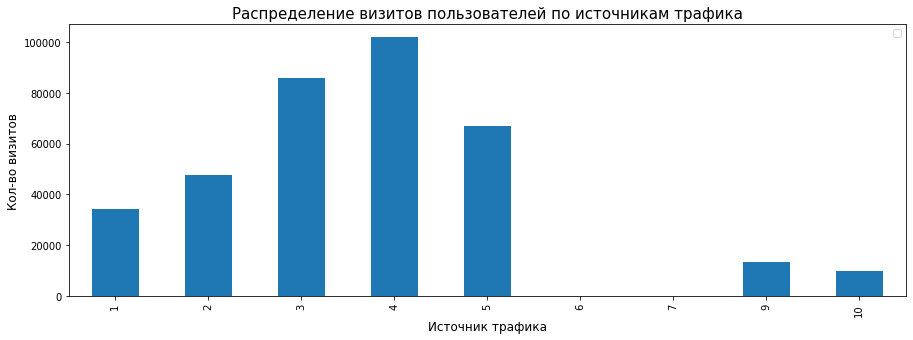

In [18]:
# посмотрим распределение визитов по источникам

ax = visits.groupby('source_id').agg({'uid':'count'}).plot(figsize=(15,5), kind='bar')
ax.set_title('Распределение визитов пользователей по источникам трафика', fontsize=15)
ax.set_xlabel('Источник трафика', fontsize=12)
ax.legend('')
ax.set_ylabel('Кол-во визитов', fontsize=12);

> На графике показано распределение визитов пользователей по источникам трафика. При этом один пользователь мог зайти с разным источником трафика и, соответственно, попасть сразу в разные источники одновременно.<br/>
Видим, что по 6 и 7 источникам очень мало визитов. Наибольшее число визитов у источников 3 и 4.


<b><font size=3>Промежуточный вывод:</font></b><br/>

Во всех таблицах: 

* Изменили названия столбцов на более удобные.
* Изменили тип в столбцах с датами на datetime. Также заменили в столбцах типы int64, float64 на более подходящие, но занимающие меньше памяти.

В таблице orders есть заказ за 01.06.2018г. В остальных таблицах данные по 31.05.2018г. Поэтому этот заказ был удален.<br/>
Посмотрели распределение по устройствам, с которых заходил пользователь: 73% визитов было совершено с компьютера и 27% визитов было сделано с планшета или телефона.<br/>
Распределение визитов пользователей по источникам показало, что по 6 и 7 источникам очень мало визитов. Наибольшее число визитов у источников 3 и 4. Также по 6,7 источникам нет расходов.

<b><font size=5>3. Расчет метрик</font></b><a name="3."></a>

<b><font size=4>3.1. Продуктовые метрики</font></b><a name="3.1."></a>

<b><font size=3>3.1.1. Расчет DAU, WAU, MAU</font></b><a name="3.1.1."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Рассчитаем DAU, WAU и MAU. Вычислим средние значения этих метрик за весь период. Отобразим изменения метрик во времени на графиках.

In [19]:
# Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

visits['session_date'] = visits['start_ts'].dt.date
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week

visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_year,session_month,session_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,12,51
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2,8
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,7,26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,5,20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,12,52


In [20]:
# посчитаем метрики

dau_total = visits.groupby('session_date').agg({'uid':'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()

print(f"DAU - кол-во уникальных пользователей в день: {int(dau_total)}")
print(f"WAU - кол-во уникальных пользователей в неделю: {int(wau_total)}")
print(f"MAU - кол-во уникальных пользователей в месяц: {int(mau_total)}")

DAU - кол-во уникальных пользователей в день: 907
WAU - кол-во уникальных пользователей в неделю: 5716
MAU - кол-во уникальных пользователей в месяц: 23228


In [21]:
# рассчитаем sticky factor

print(f'sticky factor по отношению к месячной аудитории равен {round((dau_total[0] / mau_total[0]) * 100,2)}%')
print(f'sticky factor по отношению к недельной аудитории равен {round((dau_total[0] / wau_total[0]) * 100,2)}%')

sticky factor по отношению к месячной аудитории равен 3.91%
sticky factor по отношению к недельной аудитории равен 15.88%


> sticky factor по отношению к месячной аудитории совсем невысокий. Значит, пользователи не задерживаются на сайте.

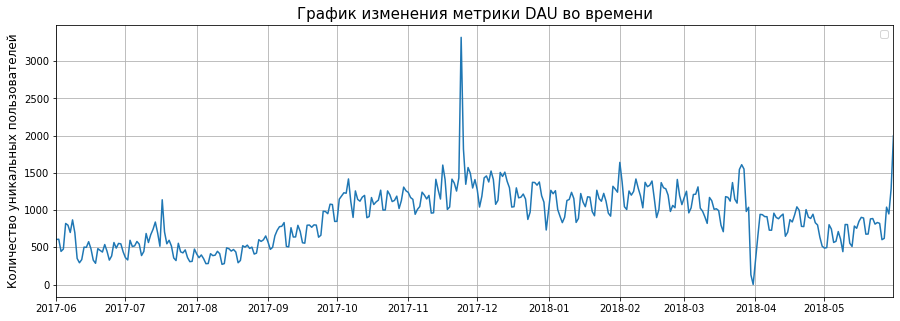

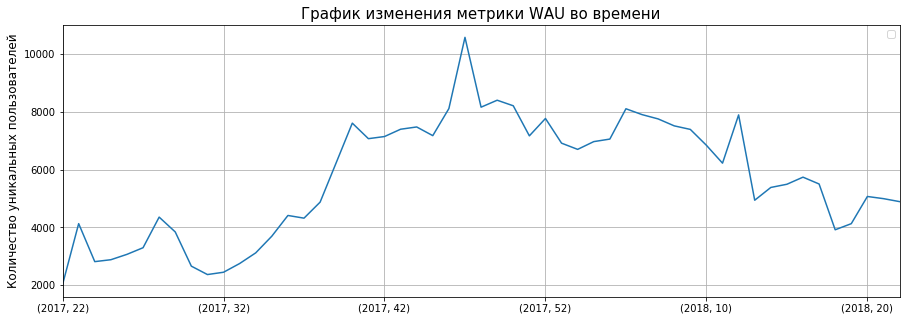

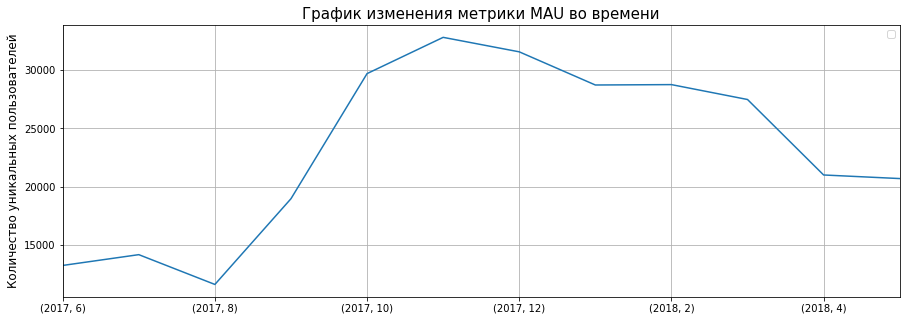

In [22]:
dau = visits.groupby('session_date').agg({'uid':'nunique'})
wau = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
mau = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})

metric_dict = {'DAU': dau, 'WAU': wau, 'MAU': mau}
for key, value in metric_dict.items():
    ax = value.plot(figsize = (15, 5), grid=True)
    ax.set_title(f"График изменения метрики {key} во времени", fontsize=15)
    ax.set_ylabel('Количество уникальных пользователей', fontsize=12)
    ax.set_xlabel('')
    ax.legend('')

> По графикам видим, что рост количества уникальных пользователей приходится на ноябрь-январь, т.е. ближе к новогодним праздникам. Что довольно логично. Пик уникальных пользователей в день приходится на конец ноября - черная пятница.<br/>
Низкий сезон приходится на июнь-август 2017г, спад уникальных пользователей также идет с апреля 2018г. Возможно, это связано с тем, что начиная с весны люди уезжают на дачы, море, в отпуск. В связи с этим, гораздо меньше ходят на различные мероприятия.<br/>
Посмотрим в какие именно дни были аномально большое и аномально маленькое число посетителей.

In [23]:
print('День с минимальным кол-вом посетителей')
print('--------------------------------------')
display(dau.reset_index().sort_values(by='uid').iloc[0])

print('День с максимальным кол-вом посетителей')
print('--------------------------------------')
display(dau.reset_index().sort_values(by='uid', ascending=False).iloc[0])

День с минимальным кол-вом посетителей
--------------------------------------


session_date    2018-03-31
uid                      1
Name: 303, dtype: object

День с максимальным кол-вом посетителей
--------------------------------------


session_date    2017-11-24
uid                   3319
Name: 176, dtype: object

> Аномально низкое кол-во посетителей было 31 марта в 2018г. Возможная причина, думаю, это ошибка при выгрузке, может сбилось время. Максимальное количество пользователей приходится на 24 ноября 2017г - черную пятницу.

<b><font size=3>3.1.2. Расчет числа сессий в день</font></b><a name="3.1.2."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Определим, сколько раз за день пользователи в среднем заходят на сайт. Построим график, отражающий изменения метрики во времени.

In [24]:
sessions_per_user = visits.groupby('session_date').agg({'uid':['count', 'nunique']}) # число сессий в день
sessions_per_user.columns = ['n_sessions', 'n_users'] # переименуем столбцы для удобства
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users'] # среднее число сессий
                                                                                                    # для каждого пользователя

print(f"В среднем за день заходят {round(sessions_per_user['sessions_per_user'].mean(),2)} раз")

В среднем за день заходят 1.08 раз


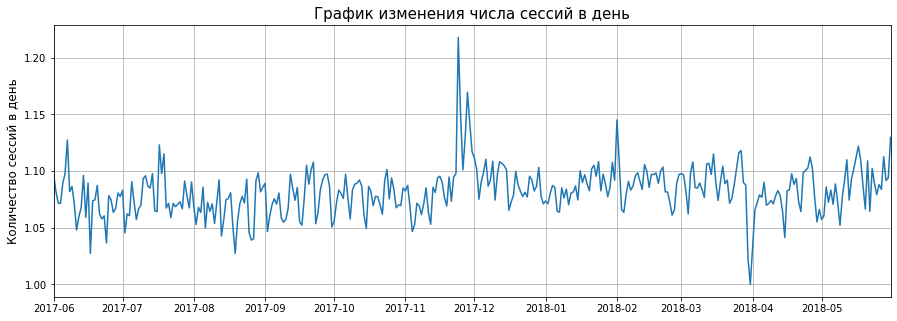

In [25]:
ax = sessions_per_user['sessions_per_user'].plot(figsize=(15,5), grid=True)
ax.set_title(f"График изменения числа сессий в день", fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Количество сессий в день', fontsize=12);

> Видим, что число сессий в день также растет с ноября по январь. Это согласуется с предыдущими метриками. Пик сессий также приходится на черную пятницу.

<b><font size=3>3.1.3. Расчет ASL</font></b><a name="3.1.3."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Исследуем, сколько времени пользователи проводят на сайте. Узнаем продолжительность типичной пользовательской сессии за весь период.

Для нахождения средней продолжительности сессии или ASL посчитаем длину всех сессий и вычислим среднее:

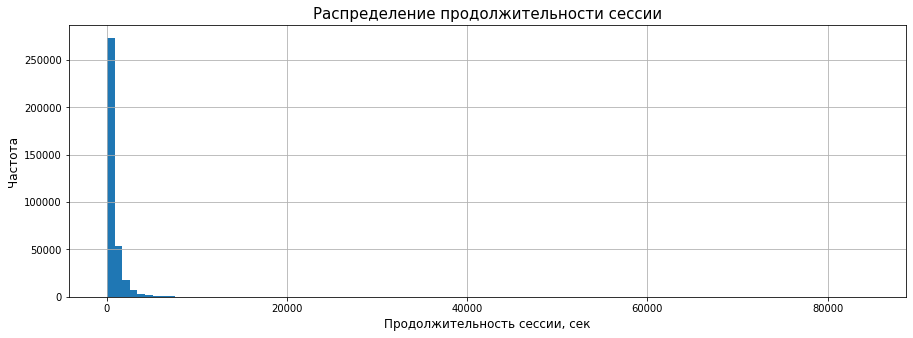

In [26]:
# вычисляем длину сессии в секундах для каждой сессии
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

# взглянем на распределение, чтобы выбрать подходящую среднюю меру
ax = visits['session_duration_sec'].hist(figsize=(15,5), bins=100)
ax.set_title(f"Распределение продолжительности сессии", fontsize=15)
ax.set_xlabel('Продолжительность сессии, сек', fontsize=12)
ax.set_ylabel('Частота', fontsize=12);

>Наше распределение далеко от нормального, поэтому вместо среднего или медианы рассчитаем моду.

In [27]:
asl = visits['session_duration_sec'].mode()
print(f"Средняя продолжительность сессии: {round(asl[0],2)} секунд")

Средняя продолжительность сессии: 60 секунд


> При падении средней продолжительности сессии, важно выдвинуть гипотезы, почему так могло случиться.

Оценим, сильно ли меняется метрика в течение года.

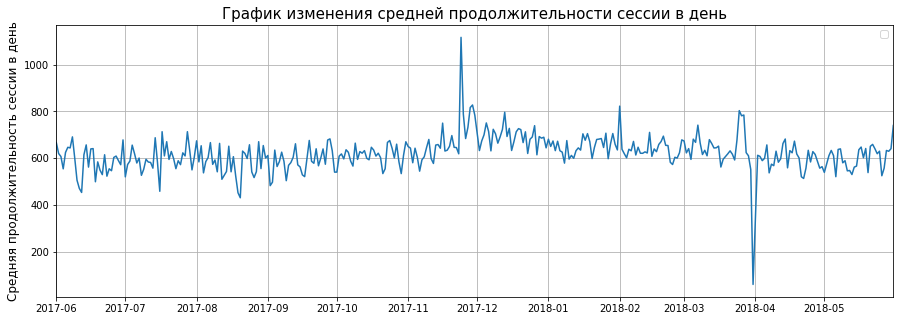

In [28]:
asl_month = visits.groupby('session_date').agg({'session_duration_sec':'mean'})
ax = asl_month.plot(figsize = (15, 5), grid=True)
ax.set_title(f"График изменения средней продолжительности сессии в день", fontsize=15)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Средняя продолжительность сессии в день', fontsize=12)
ax.legend('');

> По графику видим, что в течение года средняя продолжительность сессий несильно меняется. Перед новогодними праздниками видим небольшой рост. Однако, также как и у DAU, у средней продолжительности сессии есть два пика: в конце ноября метрика достигает максимума и резкий минимум в апреле 2018г.

<b><font size=3>3.1.4. Расчет Retention Rate</font></b><a name="3.1.4."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Далее рассчитаем Retention Rate, применяя когортный анализ. Покажем изменения метрики во времени на графике. И найдем средний Retention Rate на второй месяц «жизни» когорт.

Определим событие и период — на их основе сформируем когорту. Возьмём дату, когда пользователь впервые проявил активность на сайте. Сделаем это с помощью функции.

In [29]:
def get_cohorts(data, col_group, col_date):
    
    '''Функция формирует когорту по времени совершения первой активности (на сайте, первый заказ и пр.) 
    и считает lifetime для каждой когорты.
    '''
    
    first_activity_date = data.groupby(col_group)[col_date].min()# находим дату первой активности для каждого пользователя
    first_activity_date.name = 'first_activity_date' # переименуем столбец 
    data = data.join(first_activity_date, on=col_group) # присоединим дату первоой активности к общей таблице 
    data['activity_month'] = data[col_date].astype('datetime64[M]')  # получим день начала месяца, 
                                                                            # за который произошло событие
    data['first_activity_month'] = data['first_activity_date'].astype('datetime64[M]')# получим день начала месяца, 
                                                                                    # за который произошло  первое событие
    # теперь посчитаем lifetime пользователя в рамках когорты
    data['cohort_lifetime'] = data['activity_month'] - data['first_activity_month']
    data['cohort_lifetime'] = data['cohort_lifetime'] / np.timedelta64(1, 'M')
    data['cohort_lifetime'] = round(data['cohort_lifetime']).astype('int')
    
    # выделим первый источник, по которому пришел пользователь и добавим его в таблицу
    first_source_id = (visits.sort_values(by='start_ts')
                       .groupby('uid')['start_ts', 'source_id']
                       .first()['source_id']
                       .reset_index()
                      )
    first_source_id.rename(columns={'source_id':'first_source_id'}, inplace=True) # переименуем столбец для удобтсва
    data = data.merge(first_source_id, on='uid', how='left') # склеим таблицы
    
    return data

In [30]:
# создаем когорты
visits = get_cohorts(visits, 'uid', 'start_ts')

print('Таблица visits в разбивке по когортам')
print('-------------------------------------')
visits.head()

Таблица visits в разбивке по когортам
-------------------------------------


,device,end_ts,source_id,start_ts,uid,session_date,session_year,session_month,session_week,session_duration_sec,first_activity_date,activity_month,first_activity_month,cohort_lifetime,first_source_id
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,12,51,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0,4
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2,8,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0,2
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,7,26,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0,5
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,5,20,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2,4
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,12,52,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0,3


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённую «неделю жизни»:

In [31]:
#считаем кол-во пользователей для каждой когорты
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

# переименуем столбец для удобства
cohorts.rename(columns={'uid':'n_users'}, inplace=True)

print('Таблица когорт пользователей в зависимости от даты первого посещения сайта')
print('--------------------------------------------------------------------------')
print(cohorts.head())

Таблица когорт пользователей в зависимости от даты первого посещения сайта
--------------------------------------------------------------------------
  first_activity_month  cohort_lifetime  n_users
0           2017-06-01                0    13259
1           2017-06-01                1     1043
2           2017-06-01                2      713
3           2017-06-01                3      814
4           2017-06-01                4      909


Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц.

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц:

In [32]:
# считаем кол-во пользователей на нулевой месяц
initial_users_count = cohorts.loc[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'n_users']]

# переименуем столбец для удобства
initial_users_count = initial_users_count.rename(columns={'n_users':'cohort_users'}) 

# объединим данные по когортам с исходным количеством пользователей в когорте
cohorts = cohorts.merge(initial_users_count,on='first_activity_month') 

# рассчитаем Retention Rate. 
# разделим количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте:
cohorts['retention_rate'] = cohorts['n_users'] / cohorts['cohort_users']

# проверка
cohorts.head()

,first_activity_month,cohort_lifetime,n_users,cohort_users,retention_rate
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


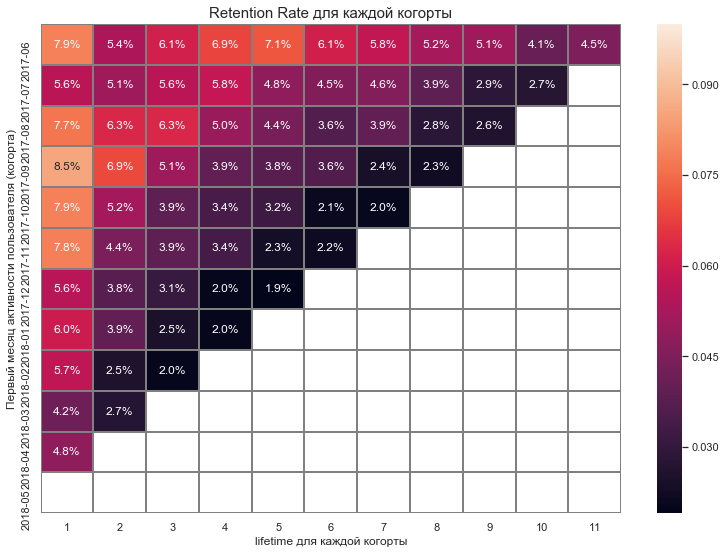

In [33]:
# построим сводную таблицу и создадим тепловую карту

cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m') # обрежем дату до месяца

retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention_rate') 


sns.set(style='white')
plt.figure(figsize=(13, 9))
ax = sns.heatmap(retention_pivot.loc[:, retention_pivot.columns!=0], 
                 annot=True, 
                 fmt='.1%', 
                 linewidths=1, 
                 linecolor='gray', 
                 vmax=0.1);
plt.title('Retention Rate для каждой когорты', fontsize=15)
ax.set_xlabel('lifetime для каждой когорты', fontsize=12)
ax.set_ylabel('Первый месяц активности пользователя (когорта)', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(),rotation=90);

> Видим, что после первого захода на сайт в сл.месяце заходят уже гораздо меньше пользователей, около 5-8%. С каждым последующим месяцем retention rate падает. Найдем средний retention rate на второй месяц жизни когорт.

In [34]:
# посчитаем средний retention_rate на второй месяц жизни когорт
retention_rate_2 = cohorts.loc[cohorts['cohort_lifetime'] == 1, 'retention_rate'].mean()

print(f"Средний retention rate на второй месяц жизни когорт равен {round(retention_rate_2 * 100,1)}%")

Средний retention rate на второй месяц жизни когорт равен 6.5%


> Уже на второй месяц жизни когор retention rate снижается до 6.5%. Наверное это логично, т.к. люди редко ходят каждый месяц на различные мероприятия, в связи с чем и мало покупают билетов в яндекс.афише.

<b><font size=3>3.1.5. Промежуточный вывод</font></b><a name="3.1.5."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

*Продуктовые метрики:*

* Рассчет DAU, WAU и MAU показал рост количества уникальных пользователей приходится на ноябрь-январь, т.е. черную пятницу и ближе к новогодним праздникам. 
* Число сессий в день также растет с ноября по январь. Пик сессий также приходится на черную пятницу 24 ноября 2018г.
* Средняя продолжительность сессии составила 60 секунд.
* После первого захода на сайт в сл.месяце заходят уже гораздо меньше пользователей, около 5-8%. С каждым последующим месяцем retention rate падает. Наверное, это нормально, т.к. не каждый пользователь хочет искать мероприятия каждый месяц. Но, возможно, что-то происходит с сайтом и нужна проверка.


<b><font size=4>3.2. Метрики электронной коммерции</font></b><a name="3.2."></a><br/>

<b><font size=3>3.2.1. Расчет среднего времени с момента первого посещения сайта до совершения покупки</font></b><a name="3.2.1."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.

In [35]:
# выделим дату певой покупки
first_buy_date = orders.groupby('uid')['buy_ts'].min()
first_buy_date.name = 'first_buy_date'

# присоединим дату первой покупки по каждому покупателю  к таблице visits
visits = visits.join(first_buy_date, on='uid') 

#преобразуем дату, убрав время (для удобства)
visits['first_activity_date'] = pd.to_datetime(visits['first_activity_date'].dt.normalize())
visits['first_buy_date'] = pd.to_datetime(visits['first_buy_date'].dt.normalize())
visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_year,session_month,session_week,session_duration_sec,first_activity_date,activity_month,first_activity_month,cohort_lifetime,first_source_id,first_buy_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,12,51,1080,2017-12-20,2017-12-01,2017-12-01,0,4,NaT
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2,8,1680,2018-02-19,2018-02-01,2018-02-01,0,2,NaT
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,7,26,0,2017-07-01,2017-07-01,2017-07-01,0,5,NaT
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,5,20,1440,2018-03-09,2018-05-01,2018-03-01,2,4,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,12,52,0,2017-12-27,2017-12-01,2017-12-01,0,3,NaT


In [36]:
# добавим столбец с разницей между первым заходом на сайт и первой покупкой
visits['fist_activity_buy_diff'] = visits['first_buy_date'] - visits['first_activity_date']

print(f"В среднем {visits['fist_activity_buy_diff'].mean()} между первым заходом на сайт и покупкой")

В среднем 33 days 17:08:17.050096 между первым заходом на сайт и покупкой


>Видим, что не у всех пользователей есть покупки. В среднем проходит 33 дня с момента первого посещения сайта до совершения покупки. Это довольно много. Наверное, было бы нормой, если между первым заходом на сайт и совершением покупки проходит менее 2-7 дней. Скорее всего есть выбросы, т.е.пользователи, у которых прошло много времени между заходом на сайт и покупкой. Посмотрим  на количество пользователей, совершивших покупку в тот же день, через день и т.д.

In [37]:
print('Количество пользователей в разбивке по времени, которое прошло между первым заходом на сайт и первой покупкой')
print('--------------------------------------------------------------------------------------------------------------')
visits.groupby('fist_activity_buy_diff').agg({'uid':'nunique'})

Количество пользователей в разбивке по времени, которое прошло между первым заходом на сайт и первой покупкой
--------------------------------------------------------------------------------------------------------------


,uid
fist_activity_buy_diff,
0 days,25039
1 days,1965
2 days,685
3 days,452
4 days,386
5 days,307
6 days,264
7 days,237
8 days,216


>Основная часть пользователей все таки совершает покупку в тот же день, в который и заходила на сайт, либо на сл.день. Но есть пользователи, которые возвращаются за покупками через год. Из-за таких выбросов и среднее время получилось 33 дня.

In [38]:
print(f"В среднем {visits['fist_activity_buy_diff'].median()} между первым заходом на сайт и покупкой")
print(f"Мода равна {visits['fist_activity_buy_diff'].mode()[0]} между первым заходом на сайт и покупкой")

В среднем 1 days 00:00:00 между первым заходом на сайт и покупкой
Мода равна 0 days 00:00:00 между первым заходом на сайт и покупкой


> Расчет медианы показал, что все таки в среднем между первым посещением сайта и покупкой проходит один день.  А вот наиболее часто встречается, то, что пользователи совершают покупку в тот же день.

<b><font size=3>3.2.2. Расчет среднего количества покупок на одного покупателя</font></b><a name="3.2.2."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Рассчитаем среднее количество покупок на одного покупателя за 6 месяцев. 

In [39]:
orders_per_user = round(orders[orders['buy_ts'] >= '2017-12-01' ].groupby('uid')['uid'].count().mean(),2)
print(f"В среднем на одного покупателя за 6 месяцев (c декабря 2017 по май 2018) приходится {orders_per_user} заказов")

В среднем на одного покупателя за 6 месяцев (c декабря 2017 по май 2018) приходится 1.34 заказов


In [40]:
# посчитаем средний чек по когортам
orders = get_cohorts(orders, 'uid', 'buy_ts') # сформируем когорты
orders['first_activity_month'] = orders['first_activity_month'].dt.strftime('%Y-%m-%d')
orders['activity_month'] = orders['activity_month'].dt.strftime('%Y-%m-%d')

# создадим  таблицу для подсчета кол-ва покупок на каждого покупателя в каждой когорте
orders_per_user_cohorts = (orders[orders['buy_ts'] >= '2017-12-01' ]
                           .groupby(['first_activity_month', 'uid'])
                           .agg({'uid':'count'})
                          )
orders_per_user_cohorts = orders_per_user_cohorts.rename(columns={'uid':'cnt_uid'}).reset_index()

# рассчитаем среднее кол-во покупок на одного покупателя для каждой когорты 
orders_per_user_cohorts_mean = orders_per_user_cohorts.groupby('first_activity_month')['cnt_uid'].mean().round(2)
orders_per_user_cohorts_mean.name = 'mean_orders' #переименуем столбец для удобства

print('Среднее кол-во покупок на одного покупателя в каждой когорте за период с декабря 2017г по май 2018г')
print('---------------------------------------------------------------------------------------------------')
orders_per_user_cohorts_mean.reset_index()

Среднее кол-во покупок на одного покупателя в каждой когорте за период с декабря 2017г по май 2018г
---------------------------------------------------------------------------------------------------


,first_activity_month,mean_orders
0,2017-06-01,5.36
1,2017-07-01,2.17
2,2017-08-01,2.51
3,2017-09-01,2.35
4,2017-10-01,1.87
5,2017-11-01,2.14
6,2017-12-01,1.34
7,2018-01-01,1.28
8,2018-02-01,1.22
9,2018-03-01,1.27


> Если рассматривать когорты с 2017-06-01 по 2017-12-01 (т.к. они прожили 6 месяцев и более, а остальные прожили менее 6 месяцев), то у когорты 2017-06-01 самое высокое кол-во покупок на покупателя.

<b><font size=3>3.2.3. Расчет среднего чека</font></b><a name="3.2.3."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Посмотрим как pза полгода (с декабря 2017 по май 2018г) менялся средний чек или среднее количество покупок на одного покупателя с течением времени и построим график.

In [41]:
# посчитаем среднюю выручку в каждом месяце
mean_revenue = orders[orders['buy_ts'] >= '2017-12-01'].groupby('activity_month')['revenue'].mean().round(2)

print('Средний чек в разбивке по месяцам')
print('---------------------------------')
mean_revenue.reset_index()

Средний чек в разбивке по месяцам
---------------------------------


,activity_month,revenue
0,2017-12-01,5.85
1,2018-01-01,4.11
2,2018-02-01,4.84
3,2018-03-01,5.41
4,2018-04-01,5.15
5,2018-05-01,4.77


>Самый высокий средний чек в декабре, перед новогодними праздниками. В общем, средний чек не падает ниже 4 у.е. Посмотрим на график.

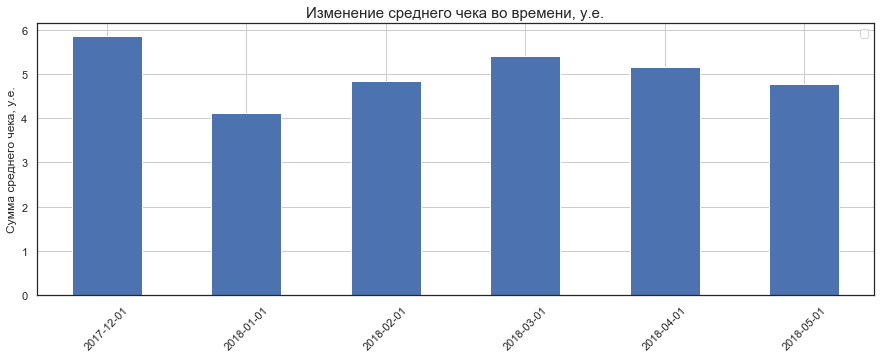

In [42]:
ax = mean_revenue.plot(figsize=(15,5), grid=True, kind='bar', rot=45)
ax.set_title('Изменение среднего чека во времени, у.е.', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Сумма среднего чека, у.е.',fontsize=12)
ax.legend('');

>  Самый высокий средний чек в декабре перед праздниками. В январе средний чек уменьшается, после чего начинается рост и в апреле снова спад. Наверное, как и с кол-вом посетителей, это связано с тем, что в теплые месяцы люди уезжают на дачу/в отпуск.

Посчитаем общий средний чек за эти полгода.

In [43]:
print(f"Средний чек за период с декабря 2017г по май 2018г составил {round(orders['revenue'].mean(),2)}")

Средний чек за период с декабря 2017г по май 2018г составил 5.0


> Немного меньше, чем в декабре 2017г. В целом, средний чек неплохой.

<b><font size=3>3.2.4. Расчет LTV</font></b><a name="3.2.4."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Выясним, как меняется LTV на покупателя по когортам. Для этого построим когорты. Но для начала посмотрим диапазон дат заказов и расходов.

In [44]:
print('Статистика по заказам')
print('---------------------')
display(orders['buy_ts'].describe())
print()
print('Статистика по расходам')
print('---------------------')
display(costs['dt'].describe())

Статистика по заказам
---------------------


count                   50414
unique                  45990
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object


Статистика по расходам
---------------------


count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

>Диапазон дат расходов совпадает с датами заказов.

In [45]:
print('Таблица orders в разбивке по когортам')
print('-------------------------------------')
orders.head()

Таблица orders в разбивке по когортам
-------------------------------------


,buy_ts,revenue,uid,first_activity_date,activity_month,first_activity_month,cohort_lifetime,first_source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3


In [46]:
#считаем кол-во покупателей для каждой когорты
cohorts = orders.groupby('first_activity_month').agg({'uid':'nunique'}).reset_index()

# переименуем столбец для удобства
cohorts.rename(columns={'uid':'n_buyers'}, inplace=True)

# сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts_total = orders.groupby(['first_activity_month', 'activity_month', 'cohort_lifetime']).agg({'revenue':'sum'}).reset_index()

# добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
report = pd.merge(cohorts, cohorts_total, on ='first_activity_month')

print('Таблица с кол-вом покупателей и выручкой по каждой когорте')
print('----------------------------------------------------------')
report.head(10)

Таблица с кол-вом покупателей и выручкой по каждой когорте
----------------------------------------------------------


,first_activity_month,n_buyers,activity_month,cohort_lifetime,revenue
0,2017-06-01,2023,2017-06-01,0,9557.490234
1,2017-06-01,2023,2017-07-01,1,981.820007
2,2017-06-01,2023,2017-08-01,2,885.340027
3,2017-06-01,2023,2017-09-01,3,1931.300049
4,2017-06-01,2023,2017-10-01,4,2068.580078
5,2017-06-01,2023,2017-11-01,5,1487.920044
6,2017-06-01,2023,2017-12-01,6,1922.739990
7,2017-06-01,2023,2018-01-01,7,1176.560059
8,2017-06-01,2023,2018-02-01,8,1119.150024
9,2017-06-01,2023,2018-03-01,9,1225.510010


Для расчета LTV посчитаем количество новых покупателей (n_buyers) и валовую прибыль за каждый месяц. При этом валовая прибыль будет равна выручке, т.к. по условию маржинальность сервиса равна 100%. Также отдельно посчитаем кол-во новых покупателей в разбивке по источникам.

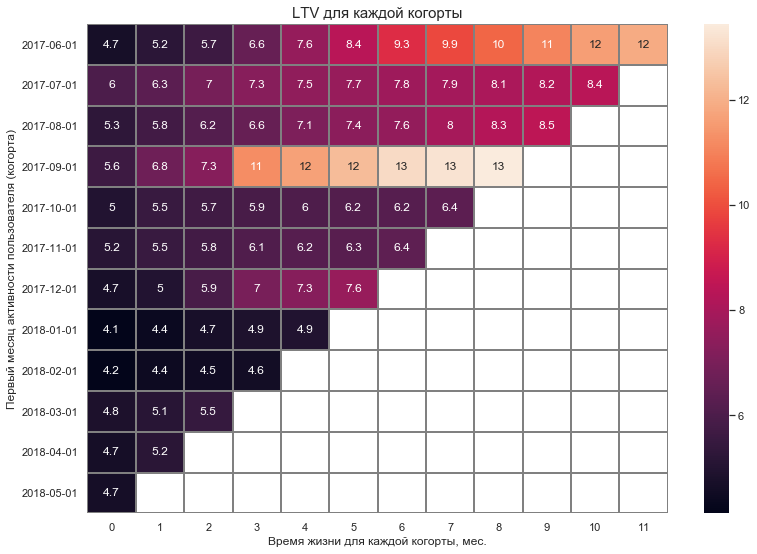

In [47]:
# считаем LTV
report['ltv'] = report['revenue'] / report['n_buyers']

# создаем сводную таблицу в разбивке по когортам и LTV
output = report.pivot_table(
    index='first_activity_month', columns='cohort_lifetime', values='ltv', aggfunc='mean'
)

# считаем накопительный LTV
ltv_cumsum = output.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(13, 9))
ax = sns.heatmap(ltv_cumsum, annot=True, linewidths=1, linecolor='gray');
plt.title('LTV для каждой когорты', fontsize=15)
ax.set_xlabel('Время жизни для каждой когорты, мес.', fontsize=12)
ax.set_ylabel('Первый месяц активности пользователя (когорта)', fontsize=12);

> Если рассматривать те когорты, которые прожили 6 и более месяцев, то выделяется сентябрьская когорта. В ней покупатель в среднем приносит больше всего денег.

Рассчитаем средний LTV по когортам за 6 месяцев; в расчёт включим когорты, «прожившие» не менее 6 месяцев.

In [48]:
ltv_mean = round(ltv_cumsum[5].mean(),2)

print(f"Средний LTVза 6 месяцев по когортам, прожившим не менее 6 месяцев, равен {ltv_mean}")

Средний LTVза 6 месяцев по когортам, прожившим не менее 6 месяцев, равен 7.97


<b><font size=3>3.2.5. Промежуточный вывод по метрикам электронной коммерции</font></b><a name="3.2.5."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

*Метрики электронной коммерции*

* В среднем между первым посещением сайта и покупкой у пользователя уходит 33 дня. Это очень много. Но при более детальном рассмотрении данных заметили, что основная часть пользователей покупают в первый день посещения сайта. Но есть и такие пользователи, которые возвращаются за покупкой через год. В связи с этим стоит рассматривать медианное значение, которое как раз таки равно одному дню или моду, которая показывает, что покупку совершают в тот же день.
* В среднем на одного покупателя за 6 месяцев (c декабря 2017 по май 2018) приходится 1.34 заказов. Если рассматривать когорты с 2017-06-01 по 2017-12-01 (т.к. они прожилли 6 месяцев и более, а остальные прожили менее 6 месяцев), то у когорты 2017-06-01 самое высокое кол-во покупок на покупателя.
* Самый высокий средний чек в декабре, перед новогодними праздниками. В общем, средний чек на человека не падает ниже 4 у.е. В январе средний чек уменьшается, после чего начинается рост и в апреле снова спад. Наверное, как и с кол-вом посетителей, это связано с тем, что в теплые месяцы люди уезжают на дачу/в отпуск. 
* Если рассматривать те когорты, которые прожили 6 и более месяцев, то выделяется сентябрьская когорта. В ней покупатель в среднем приносит больше всего денег. Средний LTV по когортам, прожившим не менее 6 месяцев, равен 7.97

<b><font size=4>3.3. Маркетинговые метрики</font></b><a name="3.3."></a><br/>

Посчитаем и отобразим на графиках, как маркетинговые метрики различаются по рекламным источникам.

<b><font size=3>3.3.1. Расходы на маркетинг в разбивке по источникам</font></b><a name="3.3.1."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Посчитаем общую сумму расходов на маркетинг и сравним с общей суммой доходов. 

In [49]:
print(f"Общая сумма расходов на маркетинг с июня 2017г по май 2018г составила {round(costs['costs'].sum(),2)} у.е.")
print(f"Общая сумма доходов с июня 2017г по май 2018г составила {round(orders['revenue'].sum(),2)} y.e.")
print(f"Разница между доходами и расходам составила {round(orders['revenue'].sum() - costs['costs'].sum(),2)} y.e.")

Общая сумма расходов на маркетинг с июня 2017г по май 2018г составила 329131.59375 у.е.
Общая сумма доходов с июня 2017г по май 2018г составила 252053.78125 y.e.
Разница между доходами и расходам составила -77077.8125 y.e.


> Пока проект себя не окупил за год.

Посмотрим расходы в разбивке по источникам и изменение их во времени.

In [50]:
print('Расходы на маркетинг в разбивке по источникам')
print('---------------------------------------------')
costs.groupby('source_id').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

Расходы на маркетинг в разбивке по источникам
---------------------------------------------


,costs
source_id,
3,141321.625000
4,61073.601562
5,51757.101562
2,42806.039062
1,20833.269531
10,5822.490234
9,5517.490234


> Наибольшее расходы за год были по источнику с номером 3, наименьшие по источникам 10 и 9.

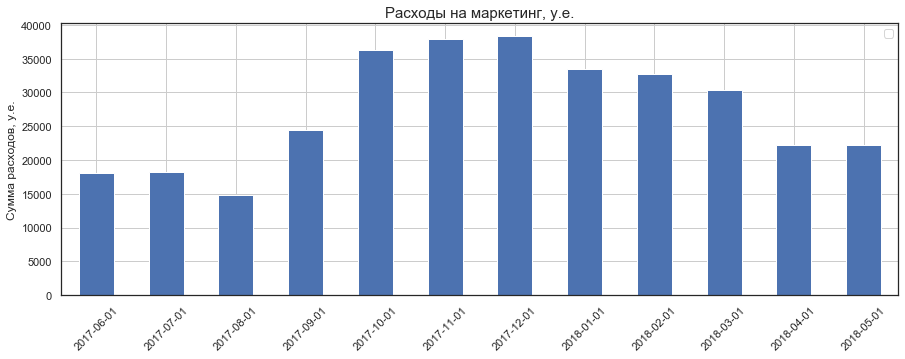

In [51]:
# выделим начало месяца
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
costs['dt_month'] = costs['dt_month'].dt.strftime('%Y-%m-%d')

# группируем расходы по каждому месяцу и построим график
ax = costs.groupby('dt_month').agg({'costs':'sum'}).plot(kind='bar', rot=45, grid=True, figsize=(15,5))
ax.set_title('Расходы на маркетинг, у.е.', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Сумма расходов, у.е.', fontsize=12)
plt.legend('');

> Начиная с октября 2017г расходы на маркетинг выросли. С января 2018г наблюдается незначительное падение расходов.

<b><font size=3>3.3.2. CAC в разбивке по источникам</font></b><a name="3.3.2."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Сначала рассчитаем САС для каждой когорты.

In [52]:
# посчитаем расходы по каждой когорте
costs['dt_month'] = pd.to_datetime(costs['dt_month'])
costs_cohort = costs.groupby('dt_month').agg({'costs':'sum'})
report['first_activity_month'] = pd.to_datetime(report['first_activity_month']) # переведем обратно в дату для соединения таблиц

# соединим таблицу costs_cohort и cohort_sizes
report_new = pd.merge(costs_cohort, report, left_on = 'dt_month', right_on = 'first_activity_month')

# посчитаем САС, поделив расходы по когорте на кол-во людей в ней
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

print('Добавили в таблицу посчитанный САС')
print('----------------------------------')
report_new.head(10)

Добавили в таблицу посчитанный САС
----------------------------------


,costs,first_activity_month,n_buyers,activity_month,cohort_lifetime,revenue,ltv,cac
0,18015.0,2017-06-01,2023,2017-06-01,0,9557.490234,4.724414,8.905091
1,18015.0,2017-06-01,2023,2017-07-01,1,981.820007,0.485329,8.905091
2,18015.0,2017-06-01,2023,2017-08-01,2,885.340027,0.437637,8.905091
3,18015.0,2017-06-01,2023,2017-09-01,3,1931.300049,0.954671,8.905091
4,18015.0,2017-06-01,2023,2017-10-01,4,2068.580078,1.022531,8.905091
5,18015.0,2017-06-01,2023,2017-11-01,5,1487.920044,0.735502,8.905091
6,18015.0,2017-06-01,2023,2017-12-01,6,1922.739990,0.950440,8.905091
7,18015.0,2017-06-01,2023,2018-01-01,7,1176.560059,0.581592,8.905091
8,18015.0,2017-06-01,2023,2018-02-01,8,1119.150024,0.553213,8.905091
9,18015.0,2017-06-01,2023,2018-03-01,9,1225.510010,0.605788,8.905091


In [53]:
print(f"Средний САС на одного покупателя для всего проекта равен {round(report_new['cac'].mean(), 1)} у.е.")

Средний САС на одного покупателя для всего проекта равен 9.3 у.е.


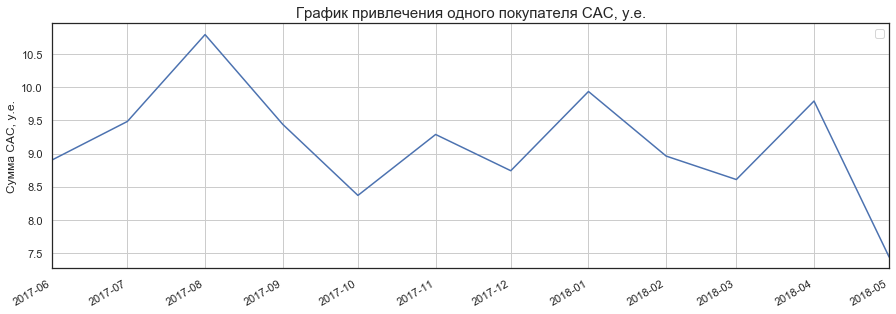

In [54]:
ax = report_new.plot(x='first_activity_month', y='cac', figsize=(15,5), grid=True)
ax.set_title('График привлечения одного покупателя CAC, у.е.', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Сумма САС, у.е.', fontsize=12)
ax.legend('');


> График показывает, что стоимость привлечения одного покупателя резко выросла в августе 2017г и упала в октябре 2018г. Посмотрим как ведет себя САС в разбивке по источникам.

Посчитаем LTV в разбивке по источникам, затем САС. В сл.пункте посчитаемобщий ROMI и  ROMI в разбивке по источникам.

In [55]:
# для начала добавим источник в таблицу report

# посчитаем количество новых покупателей (n_buyers) за каждый месяц и по каждому источнику
cohort_source_sizes = orders.groupby(['first_activity_month','first_source_id']).agg({'uid':'nunique'}).reset_index()
cohort_source_sizes.rename(columns={'uid':'n_buyers_source'}, inplace=True)

#изменим индекс
cohort_source_sizes = cohort_source_sizes.set_index(['first_activity_month', 'first_source_id'])

print('Таблица с количеством новых покупателей в каждом месяце по каждому источнику')
print('----------------------------------------------------------------------------')
cohort_source_sizes.head()

Таблица с количеством новых покупателей в каждом месяце по каждому источнику
----------------------------------------------------------------------------


n_buyers_source
first_activity_month first_source_id                 
2017-06-01           1                            190
                     2                            235
                     3                            638
                     4                            413
                     5                            384

In [56]:
# сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку по каждому источнику
cohorts_source = (orders.groupby(['first_activity_month', 'activity_month', 'cohort_lifetime', 'first_source_id'])
                  .agg({'revenue':'sum'})
                  .reset_index()
                 )
                                                                                                
# изменим индекс
cohorts_source = cohorts_source.set_index(['first_activity_month', 'first_source_id'])

# добавим в таблицу cohorts_source данные о том, сколько людей первый раз совершили покупку в каждый месяц по источникам
report_source = cohorts_source.join(cohort_source_sizes) 

print('Таблица с общей суммой выручки  и кол-вом людей, совершивших покупку по каждой когорте в разрезе источников')
print('-----------------------------------------------------------------------------------------------------------')
report_source.head()

Таблица с общей суммой выручки  и кол-вом людей, совершивших покупку по каждой когорте в разрезе источников
-----------------------------------------------------------------------------------------------------------


activity_month  cohort_lifetime  \
first_activity_month first_source_id                                   
2017-06-01           1                   2017-06-01                0   
                     1                   2017-07-01                1   
                     1                   2017-08-01                2   
                     1                   2017-09-01                3   
                     1                   2017-10-01                4   

                                          revenue  n_buyers_source  
first_activity_month first_source_id                                
2017-06-01           1                1378.699951              190  
                     1                 414.980011              190  
                     1                 419.429993              190  
                     1                 714.239990              190  
                     1                 811.200012              190

In [57]:
# считаем LTV

report_source['ltv_source'] = report_source['revenue'] / report_source['n_buyers_source']

print('Посчитанный LTV в разбивке по источникам')
print('----------------------------------------')
report_source.head(10)

Посчитанный LTV в разбивке по источникам
----------------------------------------


activity_month  cohort_lifetime  \
first_activity_month first_source_id                                   
2017-06-01           1                   2017-06-01                0   
                     1                   2017-07-01                1   
                     1                   2017-08-01                2   
                     1                   2017-09-01                3   
                     1                   2017-10-01                4   
                     1                   2017-11-01                5   
                     1                   2017-12-01                6   
                     1                   2018-01-01                7   
                     1                   2018-02-01                8   
                     1                   2018-03-01                9   

                                          revenue  n_buyers_source  ltv_source  
first_activity_month first_source_id                                            
2017-06-01           1                1378.699951              190    7.256316  
                     1                 414.980011              190    2.184105  
                     1                 419.429993              190    2.207526  
                     1                 714.239990              190    3.759158  
                     1                 811.200012              190    4.269474  
                     1                 389.339996              190    2.049158  
                     1                 490.480011              190    2.581474  
                     1                 479.230011              190    2.522263  
                     1                 432.149994              190    2.274474  
                     1                 316.299988              190    1.664737

In [58]:
# аналогично считаем САС по источникам 

costs_source = costs.groupby(['dt_month', 'source_id']).agg({'costs':'sum'}) # считаем расходы по каждому источнику
                                                                            # для каждой когорты
costs_source = costs_source.reset_index()  

# переименуем столбец для удобства
costs_source.rename(columns= {'dt_month':'first_activity_month', 'source_id':'first_source_id', 'costs':'costs_source'}, 
                    inplace=True) 
costs_source['first_activity_month'] = costs_source['first_activity_month'].dt.strftime('%Y-%m-%d') #обрезаем дату
costs_source = costs_source.set_index(['first_activity_month', 'first_source_id'])

# соединим таблицу с ltv и таблицу с расходами по источникам
report_total_source = report_source.join(costs_source)

# считаем сас
report_total_source['cac_source'] = report_total_source['costs_source'] / report_total_source['n_buyers_source'] 

print('Таблица с расходами и САС по каждому источнику')
print('----------------------------------------------')
report_total_source.head(10)

Таблица с расходами и САС по каждому источнику
----------------------------------------------


activity_month  cohort_lifetime  \
first_activity_month first_source_id                                   
2017-06-01           1                   2017-06-01                0   
                     1                   2017-07-01                1   
                     1                   2017-08-01                2   
                     1                   2017-09-01                3   
                     1                   2017-10-01                4   
                     1                   2017-11-01                5   
                     1                   2017-12-01                6   
                     1                   2018-01-01                7   
                     1                   2018-02-01                8   
                     1                   2018-03-01                9   

                                          revenue  n_buyers_source  \
first_activity_month first_source_id                                 
2017-06-01           1                1378.699951              190   
                     1                 414.980011              190   
                     1                 419.429993              190   
                     1                 714.239990              190   
                     1                 811.200012              190   
                     1                 389.339996              190   
                     1                 490.480011              190   
                     1                 479.230011              190   
                     1                 432.149994              190   
                     1                 316.299988              190   

                                      ltv_source  costs_source  cac_source  
first_activity_month first_source_id                                        
2017-06-01           1                  7.256316   1125.609985    5.924263  
                     1                  2.184105   1125.609985    5.924263  
                     1                  2.207526   1125.609985    5.924263  
                     1                  3.759158   1125.609985    5.924263  
                     1                  4.269474   1125.609985    5.924263  
                     1                  2.049158   1125.609985    5.924263  
                     1                  2.581474   1125.609985    5.924263  
                     1                  2.522263   1125.609985    5.924263  
                     1                  2.274474   1125.609985    5.924263  
                     1                  1.664737   1125.609985    5.924263

В сл.пунке я начала строить тепловые карты для ROMI по каждому источнику и увидела, что есть источник, для которого ROMI не посчитан из-за того, что по этому источнику нет расходов. Поэтому здесь проверим на пустые значения получившуюся таблицу.

In [59]:
report_total_source[report_total_source['costs_source'].isna()]

,,activity_month,cohort_lifetime,revenue,n_buyers_source,ltv_source,costs_source,cac_source
first_activity_month,first_source_id,,,,,,,
2017-08-01,7,2017-08-01,0,1.22,1,1.22,NaN,NaN


> По источнику 7 нет расходов. Удалим эту строку из данных,т.к. в данной когорте всего один человек.

In [60]:
# удалим пропуски

report_total_source = report_total_source.dropna()

In [61]:
# создадим сводную таблицу из report_total для удобства отрисовки графика
report_total_source = report_total_source.reset_index()
report_pivot = report_total_source.groupby(['first_activity_month', 'first_source_id']).agg({'cac_source':'mean'}).reset_index()

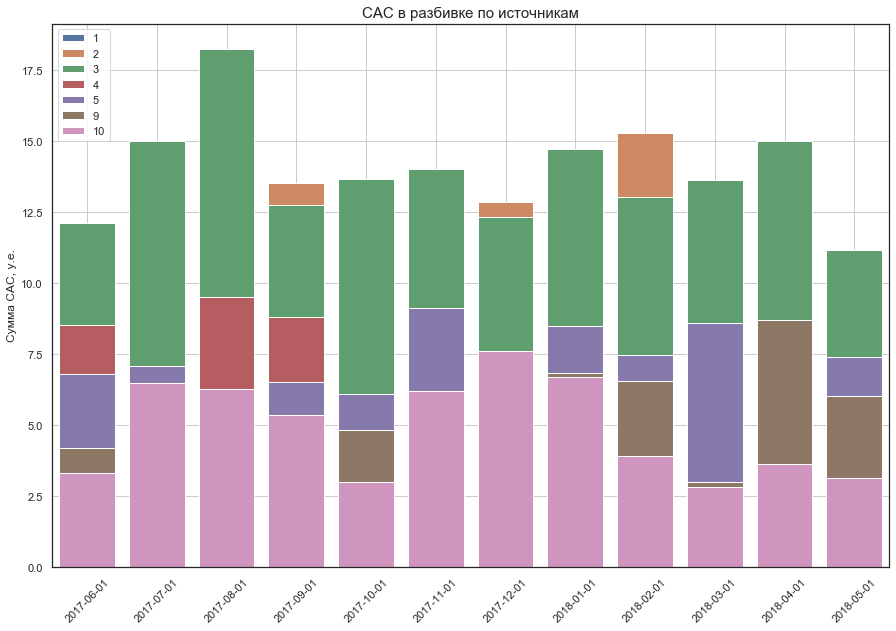

In [62]:
# построим график САС в разбивке по источникам

col = sns.color_palette('husl', n_colors=7)
plt.figure(figsize=(15,10))
ax = sns.barplot(x = 'first_activity_month', 
                 y = 'cac_source', 
                 hue = 'first_source_id', 
                 data = report_pivot, 
                 dodge=False)
ax.grid()
ax.legend(loc='upper left')
ax.set_xlabel('')
plt.xticks(rotation=45)
ax.set_ylabel('Сумма САС, у.е.', fontsize=12)
ax.set_title('САС в разбивке по источникам', fontsize=15);

> САС во всех когортах высокий у источника номер 3 и в некоторых когортах у источника 2. Самое дешевое привлечение пользователя у 10го источника.

<b><font size=3>3.3.3. Расчет ROMI по когортам в разрезе источников</font></b><a name="3.3.3."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Сначала посчитаем ROMI по каждой когорте.

In [63]:
# рассчитаем ROMI по когортам
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new['first_activity_month'] = report_new['first_activity_month'].dt.strftime('%Y-%m-%d')

print('Таблица с добавлением ROMI')
print('--------------------------')
report_new.head(10)

Таблица с добавлением ROMI
--------------------------


,costs,first_activity_month,n_buyers,activity_month,cohort_lifetime,revenue,ltv,cac,romi
0,18015.0,2017-06-01,2023,2017-06-01,0,9557.490234,4.724414,8.905091,0.530530
1,18015.0,2017-06-01,2023,2017-07-01,1,981.820007,0.485329,8.905091,0.054500
2,18015.0,2017-06-01,2023,2017-08-01,2,885.340027,0.437637,8.905091,0.049145
3,18015.0,2017-06-01,2023,2017-09-01,3,1931.300049,0.954671,8.905091,0.107205
4,18015.0,2017-06-01,2023,2017-10-01,4,2068.580078,1.022531,8.905091,0.114825
5,18015.0,2017-06-01,2023,2017-11-01,5,1487.920044,0.735502,8.905091,0.082593
6,18015.0,2017-06-01,2023,2017-12-01,6,1922.739990,0.950440,8.905091,0.106730
7,18015.0,2017-06-01,2023,2018-01-01,7,1176.560059,0.581592,8.905091,0.065310
8,18015.0,2017-06-01,2023,2018-02-01,8,1119.150024,0.553213,8.905091,0.062123
9,18015.0,2017-06-01,2023,2018-03-01,9,1225.510010,0.605788,8.905091,0.068027


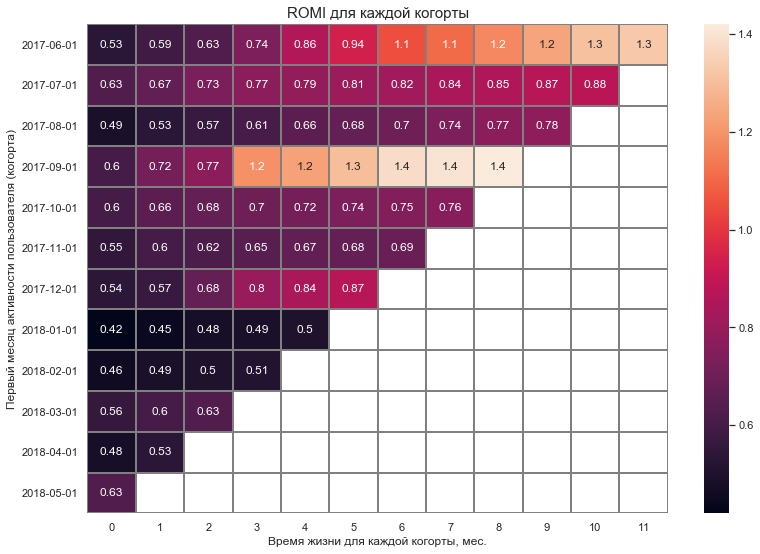

In [64]:
# посмотрим на сводную таблицу по ROMI по когортам 
report_pivot_romi = report_new.pivot_table(index='first_activity_month',
                                           columns = 'cohort_lifetime',
                                           values = 'romi',
                                           aggfunc='mean')

report_pivot_romi = report_pivot_romi.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(13, 9))
ax = sns.heatmap(report_pivot_romi, annot=True, linewidths=1, linecolor='gray');
plt.title('ROMI для каждой когорты', fontsize=15)
ax.set_xlabel('Время жизни для каждой когорты, мес.', fontsize=12)
ax.set_ylabel('Первый месяц активности пользователя (когорта)', fontsize=12);

>На 6 месяц жизни когорт самый высокий ROMI у сентябрьской когорты, она уже окупилась. Затем идет июньская когорта, ROMI близок к единице.

Теперь посчитаем ROMI по каждой когорте в разрезе источников.

In [65]:
# рассчитаем ROMI
report_total_source['romi_source'] = report_total_source['ltv_source'] / report_total_source['cac_source']

print('Таблица с добавлением ROMI по каждому источнику')
print('-----------------------------------------------')
report_total_source.head(10)

Таблица с добавлением ROMI по каждому источнику
-----------------------------------------------


,first_activity_month,first_source_id,activity_month,cohort_lifetime,revenue,n_buyers_source,ltv_source,costs_source,cac_source,romi_source
0,2017-06-01,1,2017-06-01,0,1378.699951,190,7.256316,1125.609985,5.924263,1.224847
1,2017-06-01,1,2017-07-01,1,414.980011,190,2.184105,1125.609985,5.924263,0.368671
2,2017-06-01,1,2017-08-01,2,419.429993,190,2.207526,1125.609985,5.924263,0.372625
3,2017-06-01,1,2017-09-01,3,714.239990,190,3.759158,1125.609985,5.924263,0.634536
4,2017-06-01,1,2017-10-01,4,811.200012,190,4.269474,1125.609985,5.924263,0.720676
5,2017-06-01,1,2017-11-01,5,389.339996,190,2.049158,1125.609985,5.924263,0.345892
6,2017-06-01,1,2017-12-01,6,490.480011,190,2.581474,1125.609985,5.924263,0.435746
7,2017-06-01,1,2018-01-01,7,479.230011,190,2.522263,1125.609985,5.924263,0.425751
8,2017-06-01,1,2018-02-01,8,432.149994,190,2.274474,1125.609985,5.924263,0.383925
9,2017-06-01,1,2018-03-01,9,316.299988,190,1.664737,1125.609985,5.924263,0.281003


Построим тепловые карты по ROMI для каждого источника.

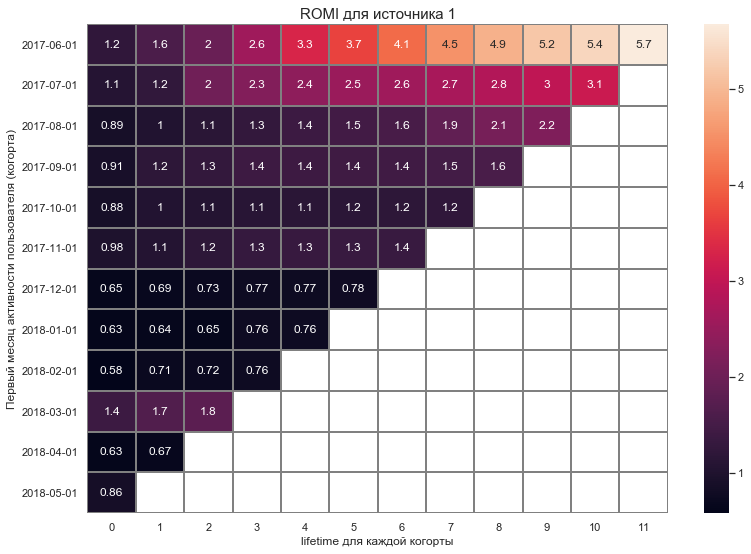

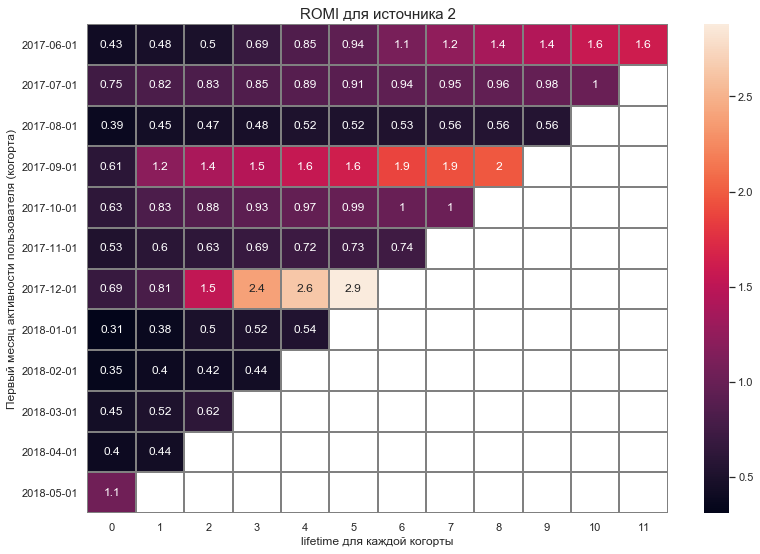

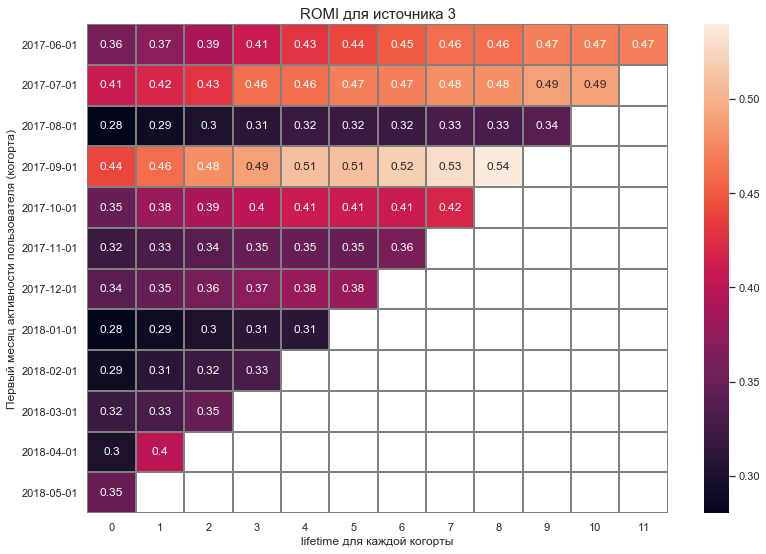

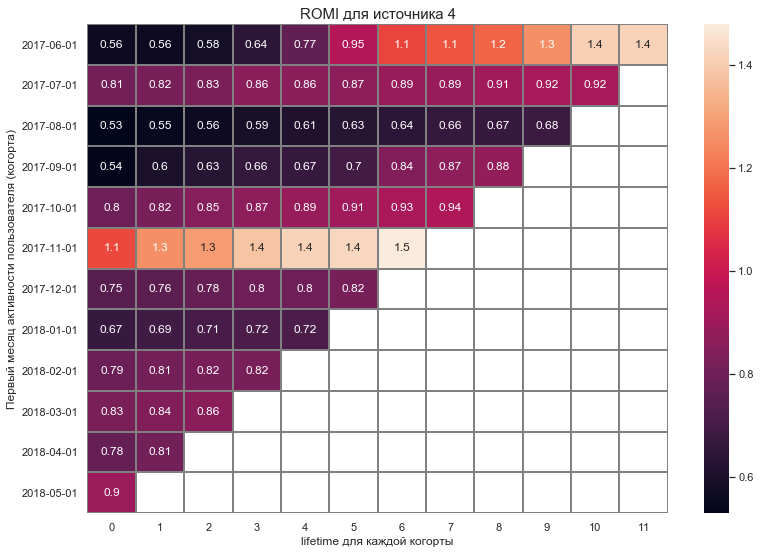

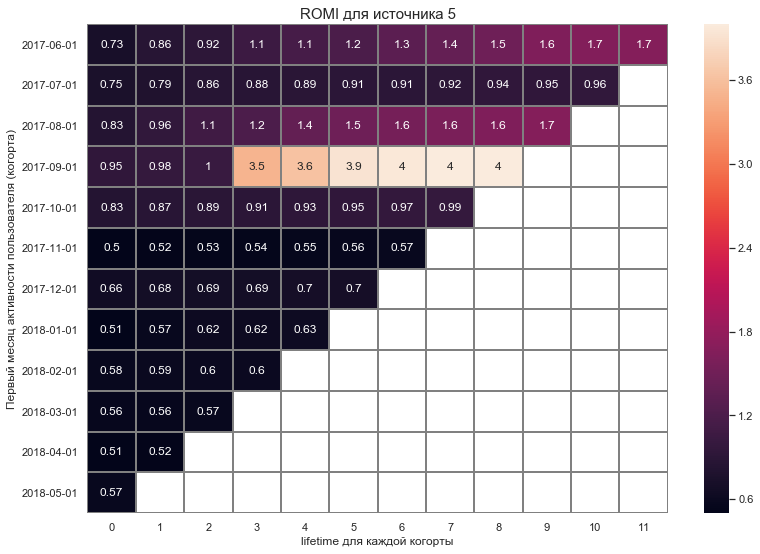

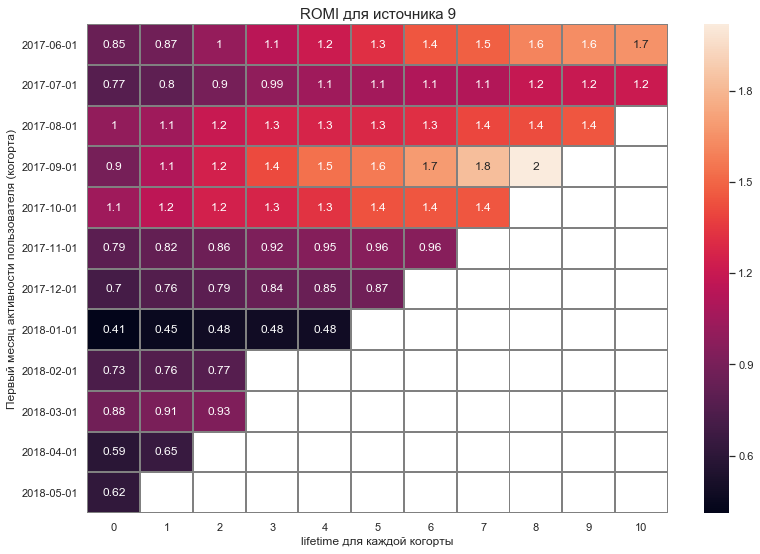

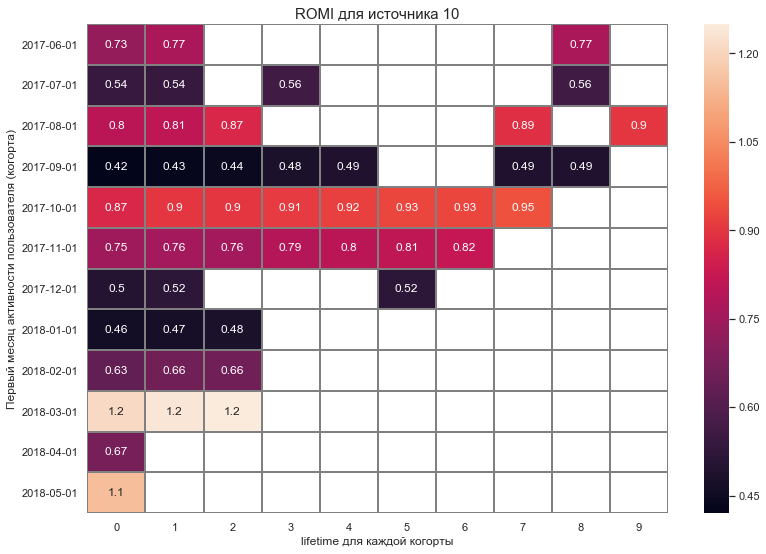

In [66]:
# создаем список всех источников
list_source = report_total_source['first_source_id'].unique().tolist()

for source_id in list_source:
    # выбираем данные по источнику
    romi_source = report_total_source.loc[report_total_source['first_source_id'] == source_id]
    # строим сводную табюлицу по этому источнику
    romi_source_pivot = romi_source.pivot_table(index='first_activity_month',
                                                columns = 'cohort_lifetime',
                                                values = 'romi_source',
                                                aggfunc='mean')
    # считаем накопительный romi
    romi_source_pivot = romi_source_pivot.cumsum(axis=1).round(2)
    # строим тепловую карту
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    ax = sns.heatmap(romi_source_pivot, annot=True, linewidths=1, linecolor='gray');
    plt.title(f'ROMI для источника {source_id}', fontsize=15)
    ax.set_xlabel('lifetime для каждой когорты', fontsize=12)
    ax.set_ylabel('Первый месяц активности пользователя (когорта)', fontsize=12);

> Будем сравнивать показатель ROMI по каждому источнику на 6й месяц жизни когорты.
По источнику 1 наилучшую окупаемость показали июньская и июльская когорты 2017г. Но с каждой сл.когортой показатель ROMI падает.
По источнику 2 наилучшая окупаемость сентябрьской и декабрьской когорт 2017г. 
По источнику 3 низкая окупаемость у всех когорт. ROMI на уровне 0.5 и ниже.
По источнику 4 наилучшая окупаемость у июньской и ноябрьской когорт 2017г.
По источнику 5 у сентябрьской когорты.
По источнику 9 примерно у всех неплохая окупаемость, на одинаковом уровне.
10 источник не очень хороший. Не для всех периодов посчитана окупаемость.

<b><font size=3>3.3.4. Промежуточный вывод по маркетинговым метрикам</font></b><a name="3.3.4."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

*Маркетинговые метрики:*

* Разница между доходами и расходам составила -77077.8125 y.e. Проект за год себя не окупил. Наибольшее расходы за год были по источнику с номером 3, наименьшие по источникам 10 и 9. Начиная с октября 2017г расходы на маркетинг выросли. С января 2018г наблюдается незначительное падение расходов.
* При этом САС у источника номер 3 самый высокий. Самое дешевое привлечение пользователя у 10го источника. Стоимость привлечения одного покупателя резко выросла в августе 2017г и упала в октябре 2018г. 
* На 6 месяц жизни когорт самый высокий ROMI у сентябрьской когорты, она уже окупилась. Затем идет июньская когорта, ROMI близок к единице. В разбивке по источникам:
                            * По источнику 3 низкая окупаемость у всех когорт.
                            * 10 источник не очень хороший. Не для всех периодов посчитана окупаемость.
                            * Хорошая окупаемость по 1му и 9му источнику. Практически все когорты окупились.


<b><font size=4>4. Общий вывод</font></b><a name="4."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

*Рекомендации:* 
* Самый дорогой пользователь приходит по 3му источнику. У него САС самый высокий. При этом у всех когорт по этому источнику низкая окупаемость, за полгода жизни когорт ROMI на уровне 0.5 и ниже. Также низкая окупаемость у 10го источника, и посчитана только для трех когорт. Т.е. денег компании пользователи с этого источника не приносят. Поэтому вкладывать деньги в источники 3 и 10 не рекомендуется.<br/>
* Хорошая окупаемость по 1му и 9му источнику. Практически все когорты окупились за полгода жизни на 100% и выше.
* Самые перспективные для компании когорты:
        * это все когорты по 1 и 9 источнику, 
        * по 5му источнику сентябрьская когорта (ROMI = 3.9 за полгода жизни когорты)
        * по 4му источнику ноябрьская когорта (ROMI = 1.4 за полгода жизни когорты)
        * по 2му источнику декабрьская когорта ((ROMI = 2.9 за полгода жизни когорты)
        * без разбивки по источникам у сентябрьской когорты самый высокий средний чек - 7.97 за полгода (с декабря 2017г по май 2018г)

ВЫВОДЫ ПО МЕТРИКАМ:<br/>

*Продуктовые метрики:*

* Рассчет DAU, WAU и MAU показал рост количества уникальных пользователей приходится на ноябрь-январь, т.е. ближе к новогодним праздникам. 
* Число сессий в день также растет с ноября по январь. Пик сессий приходится на черную пятницу 24 ноября 2017г.
* Средняя продолжительность сессии составила 60 секунд.
* После первого захода на сайт в сл.месяце заходят уже гораздо меньше пользователей, около 5-8%. С каждым последующим месяцем retention rate падает. Наверное, это нормально, т.к. не каждый пользователь хочет искать мероприятия каждый месяц. Но, возможно, что-то происходит с сайтом и нужна проверка.

*Метрики электронной коммерции*

* В среднем между первым посещением сайта и покупкой у пользователя уходит 33 дня. Это очень много. Но при более детальном рассмотрении данных заметили, что основная часть пользователей покупают в первый день посещения сайта. Но есть и такие пользователи, которые возвращаются за покупкой через год. В связи с этим стоит рассматривать медианное значение, которое как раз таки равно одному дню или моду, которая показывает, что покупку совершают в тот же день.
* В среднем на одного покупателя за 6 месяцев (c декабря 2017 по май 2018) приходится 1.34 заказов. Если рассматривать когорты с 2017-06-01 по 2017-12-01 (т.к. они прожилли 6 месяцев и более, а остальные прожили менее 6 месяцев), то у когорты 2017-06-01 самое высокое кол-во покупок на покупателя.
* Самый высокий средний чек в декабре, перед новогодними праздниками. В общем, средний чек на человека не падает ниже 4 у.е. В январе средний чек уменьшается, после чего начинается рост и в апреле снова спад. Наверное, как и с кол-вом посетителей, это связано с тем, что в теплые месяцы люди уезжают на дачу/в отпуск. 
* Если рассматривать те когорты, которые прожили 6 и более месяцев, то выделяется сентябрьская когорта. В ней покупатель в среднем приносит больше всего денег. Средний LTV по когортам, прожившим не менее 6 месяцев, равен 7.97

*Маркетинговые метрики:*

* Разница между доходами и расходам составила -77077.8125 y.e. Проект за год себя не окупил. Наибольшее расходы за год были по источнику с номером 3, наименьшие по источникам 10 и 9. Начиная с октября 2017г расходы на маркетинг выросли. С января 2018г наблюдается незначительное падение расходов.
* При этом САС у источника номер 3 самый высокий. Самое дешевое привлечение пользователя у 10го источника. Стоимость привлечения одного покупателя резко выросла в августе 2017г и упала в октябре 2018г. 
* На 6 месяц жизни когорт самый высокий ROMI у сентябрьской когорты, она уже окупилась. Затем идет июньская когорта, ROMI близок к единице. В разбивке по источникам:
                            * По источнику 3 низкая окупаемость у всех когорт.
                            * 10 источник не очень хороший. Не для всех периодов посчитана окупаемость.
                            * Хорошая окупаемость по 1му и 9му источнику. Практически все когорты окупились.
Замечание: есть посетители с источниками 6 и 7 (42 визита на сайт), но при этом покупателей с такими источниками нет.